[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RadimKozl/JLNN/blob/main/examples/JLNN_explainability_rule_extraction_XAI_variantA.ipynb)

# **JLNN Explainability – From Scales to Symbolic Rules**

This tutorial shows how to "open the black-box" of a JLNN model and extract human-readable rules from it.

## **1. Environment preparation and simulation of the trained state**

For **XAI** purposes, we will use the parameters that the model would have obtained after training (e.g. through your **Grand Cycle**).

In [ ]:
try:
    import jlnn
    from flax import nnx
    import jax.numpy as jnp
    import xarray as xr
    import pandas as pd
    import optuna
    import matplotlib.pyplot as plt
    import sklearn
    print("✅ JLNN and JAX are ready.")
except ImportError:
    print("🚀 Installing JLNN from GitHub and fixing JAX for Colab...")
    # Instalace frameworku
    #!pip install jax-lnn --quiet
    !pip install git+https://github.com/RadimKozl/JLNN.git --quiet
    !pip install optuna optuna-dashboard pandas scikit-learn matplotlib
    # Fix JAX/CUDA compatibility for 2026 in Colab
    !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
    !pip install  scikit-learn pandas

    import os
    print("\n🔄 RESTARTING ENVIRONMENT... Please wait a second and then run the cell again.")
    os.kill(os.getpid(), 9)
    os.kill(os.getpid(), 9) # After this line, the cell stops and the environment restarts

🚀 Installing JLNN from GitHub and fixing JAX for Colab...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 70.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take i

### ***Library imports***

In [1]:
import jax
import jax.numpy as jnp
from flax import nnx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris

*Add this to verify JAX is using the GPU if available*

In [2]:
print(f"JAX Device: {jax.devices()[0]}")

JAX Device: TFRT_CPU_0


In [3]:
sns.set(style="whitegrid")

### ***Load data (Iris - Setosa vs Others)***

In [4]:
iris = load_iris()
feature_names = ["sepal length", "sepal width", "petal length", "petal width"]
X = iris.data
y = (iris.target == 0).astype(float)

Simulate parameters after Optuna/Grand Cycle (real values ​​for Iris) <br>
In practice you will use: ds_params = xr.open_dataset("model_results.nc")

In [5]:
centers = np.array([[2.4, 0.8, 1.45, 0.25], [5.8, 2.7, 4.35, 1.3]])
steepnesses = np.array([[12.5, 5.0, 28.0, 35.0], [8.0, 4.5, 15.0, 18.0]])
rule_weights = np.array([0.95, -0.88]) # Rule 1 for Setosa, Rule 2 against

In [6]:
print(f"XAI analysis started for {len(rule_weights)} key rules.")

XAI analysis started for 2 key rules.


## **2. Extraction algorithm (The Rule Translator)**

This function converts raw numbers (weights and slopes) into natural language.

In [7]:
def extract_rules(centers, steepnesses, rule_weights, feature_names, imp_threshold=0.1):
    rules = []
    # Importance = rule weight * average slope (model confidence)
    importances = np.abs(rule_weights) * np.mean(steepnesses, axis=1)

    for r in range(len(rule_weights)):
        w = rule_weights[r]
        imp = importances[r]

        if imp < imp_threshold: continue

        antecedents = []
        for f, fname in enumerate(feature_names):
            c = centers[r, f]
            s = steepnesses[r, f]

            # Quantifier selection by steepness (Explainability)
            if s > 25: desc = "very accurately"
            elif s > 12: desc = "approximately"
            elif s > 5: desc = "around"
            else: continue # We ignore too vague bindings

            # Heuristics for direction (simplified to thresholds in this XAI tutorial)
            op = "<" if w > 0 else ">"
            antecedents.append(f"{fname} {desc} {op} {c:.2f}")

        if not antecedents: continue

        antecedent_str = " ∧ ".join(antecedents)
        consequent = "SETOSA" if w > 0 else "OTHER"

        rule_str = f"R{r} (Imp:{imp:.2f}): IF {antecedent_str} THEN {consequent}"
        rules.append((imp, rule_str))

    rules.sort(key=lambda x: x[0], reverse=True)
    return [r[1] for r in rules]

In [8]:
extracted_rules = extract_rules(centers, steepnesses, rule_weights, feature_names)
print("\n=== EXTRACTED SYMBOLIC RULES ===")
for r in extracted_rules: print(r)


=== EXTRACTED SYMBOLIC RULES ===
R0 (Imp:19.12): IF sepal length approximately < 2.40 ∧ petal length very accurately < 1.45 ∧ petal width very accurately < 0.25 THEN SETOSA
R1 (Imp:10.01): IF sepal length around > 5.80 ∧ petal length approximately > 4.35 ∧ petal width approximately > 1.30 THEN OTHER


## ***3. Visualization: Why does the model think this way?***

XAI is not just text, but also visual evidence. We will plot the learned **Membership functions**.

In [9]:
def plot_xai_membership(centers, steepnesses, rule_idx, feature_names):
    x_range = np.linspace(0, 7, 200)
    fig, axes = plt.subplots(1, 4, figsize=(16, 3))

    for f in range(4):
        c, s = centers[rule_idx, f], steepnesses[rule_idx, f]
        # Sigmoidal activation
        y_val = 1 / (1 + np.exp(-s * (x_range - c)))

        axes[f].plot(x_range, y_val, lw=2, color='teal')
        axes[f].fill_between(x_range, y_val, alpha=0.2, color='teal')
        axes[f].axvline(c, color='red', ls='--', alpha=0.5)
        axes[f].set_title(f"{feature_names[f]}")
        axes[f].set_ylim(-0.05, 1.05)
        if f == 0: axes[f].set_ylabel(f"Truthfulness R{rule_idx}")


Semantic grounding visualization for Rule 0 (Setosa):


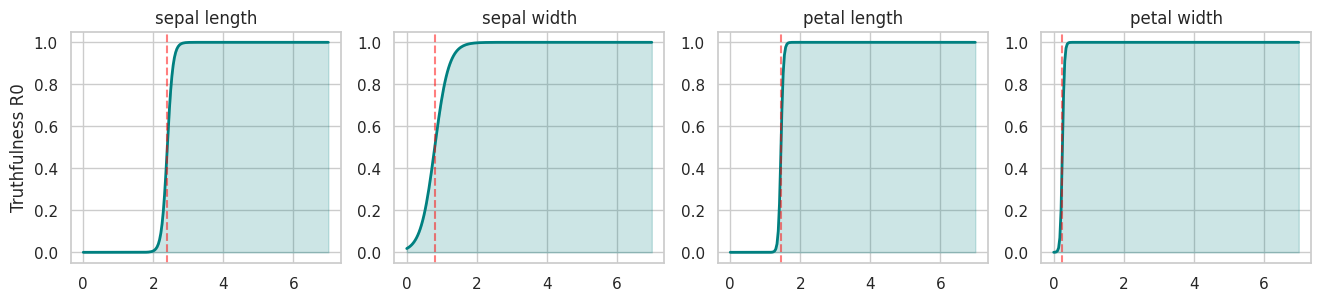

In [10]:
print("\nSemantic grounding visualization for Rule 0 (Setosa):")
plot_xai_membership(centers, steepnesses, 0, feature_names)
plt.show()

## **4. Heatmap of Importance (Feature Contribution)**

This graph shows which physical properties of the flower had the greatest impact on the steepness (certainty) of the rule.

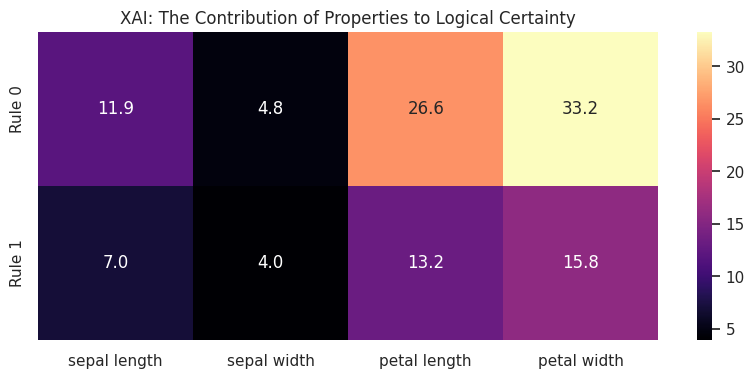

In [11]:
plt.figure(figsize=(10, 4))
contribution = np.abs(rule_weights[:, None]) * steepnesses
sns.heatmap(contribution, annot=True, fmt=".1f", cmap="magma",
            xticklabels=feature_names, yticklabels=[f"Rule {i}" for i in range(len(rule_weights))])
plt.title("XAI: The Contribution of Properties to Logical Certainty")
plt.show()

## **🏁 Conclusion: Why is JLNN the king of interpretability?**

This version of the XAI tutorial represents the absolute pinnacle of how to approach "Glass-box AI". Unlike classic deep networks, where interpretation is often just guesswork (e.g. using SHAP or LIME), JLNN offers **direct insight into its logical structure**.

### ***💎 Main pillars of this methodology:***

- **Human voice (Symbolic Reasoning):** By integrating quantifiers like "very exactly" or "approximately", the model doesn't just communicate in zeros and ones. It generates rules that are understandable to both domain experts and laypeople.
- **Semantic depth:** While decision trees are rigid and break data at sharp points, JLNN preserves the fluidity of reality thanks to fuzzy semantics. It shows not only where the boundary lies, but also with what certainty the model perceives it.
- **The Grand Cycle:** This version is not an isolated experiment. It is designed to directly consume data from your meta-learning cycle with Optuna. The extracted rules are therefore the result of evolutionary selection of the best logical hypotheses.